In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from venn import venn
import plotly.express as px
import shap
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
pd.options.display.max_columns = 50
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = (10.0, 7.0)

# protein

In [3]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006051013_ruv_min_300.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006061215_ruv_min_300.csv")
df_shap = pd.read_csv("../../result_files/shap/test_63_202006211344_eg_id.csv")

# RNA

In [8]:
df = pd.read_csv("../work_dirs/rna_common_norm/RandomForest/feature_importance_202004081135_rna_300.csv")

In [9]:
drug = '438'

In [10]:
df[['rna_common', f'importance_{drug}']].sort_values(by=[f'importance_{drug}'], ascending=False).head(30)

,rna_common,importance_438
1178,GPX8,0.004540
1139,GNG12,0.004407
413,CCN1,0.004274
2625,S100A6,0.003820
1400,ITGB1,0.003735
1483,LAMB2,0.003703
2196,PPIC,0.003291
987,FAM114A1,0.003199
2623,S100A2,0.003040
657,CTSL,0.002985


# Tissue type shap

## compute

In [12]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMClassifier

In [14]:
config_file = '../../configs/cancer_type/lgbm_grid_search_tissuetype.json'
configs = json.load(open(config_file, 'r'))

In [16]:
seed = configs['seed']
cv = StratifiedKFold(n_splits=configs['cv'], shuffle=True, random_state=seed)

data_sample = pd.read_csv('../../data/cancer_type/cancer_tissue_type_protein.tsv', sep='\t')

data_sample = data_sample.drop(['Cell_line'], axis=1)

type_count = data_sample.groupby([configs['target']]).size()
selected_types = type_count[type_count > configs['cut_off']].index.values
data_sample = data_sample[data_sample[configs['target']].isin(selected_types)].reset_index(drop=True)
proteins = np.array([x for x in data_sample.columns if '_HUMAN' in x])
X = data_sample[proteins]
y = data_sample[configs['target']]
imputer = None
if configs['imputer'] == 'mean':
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
elif configs['imputer'] == 'KNN':
    imputer = KNNImputer(missing_values=np.nan)
elif configs['imputer'] == 'zero':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
elif configs['imputer'] == 'min':
    imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=configs['min_val'])

if imputer:
    X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, shuffle=True,
                                                    test_size=0.2)

In [20]:
params = {'max_bin': 500, 'n_estimators': 700, 'num_leaves': 21, 'n_jobs': -1}
clf = LGBMClassifier(**params)

In [16]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=500,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=700, n_jobs=-1, num_leaves=21,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [17]:
explainer = shap.TreeExplainer(clf)
lgbm_shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [253]:
# pickle.dump(lgbm_shap_values, open("../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "wb"))

In [10]:
lgbm_shap_values = pickle.load(open("../../work_dirs/shap_tissue/lgbm_shap_values_tissue_14.pkl", "rb"))

In [17]:
topN = 10
shap_tissue_set = []
for tissue_shap in lgbm_shap_values:
    shap_top_proteins = proteins[np.argsort(-np.mean(np.abs(tissue_shap),axis=0))][:topN]
    shap_tissue_set.extend([f"{x}" for x in shap_top_proteins])
shap_tissue_set = set(shap_tissue_set)

## load set

In [19]:
pickle.dump(shap_tissue_set, open("../../work_dirs/shap_tissue/shap_tissue_set.pkl", "wb"))

In [4]:
shap_tissue_set = pickle.load(open("../../work_dirs/shap_tissue/shap_tissue_set.pkl", "rb"))

# rf vs en vs shap

## rank vs count excluding tissue

In [36]:
df_rf = pd.read_csv("../../work_dirs/protein/RandomForest/feature_importance_202006181311_ruv_min_300_eg_id.csv")
df_en = pd.read_csv("../../work_dirs/protein/ElasticNet/feature_importance_202006201223_ruv_min_300_eg_id.csv")
df_shap = pd.read_csv("../../result_files/shap/test_63_202006211344_eg_id.csv")

In [37]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores_eg_id.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 0)][
    'drug_id'].values

In [38]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [173]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [174]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [175]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [176]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


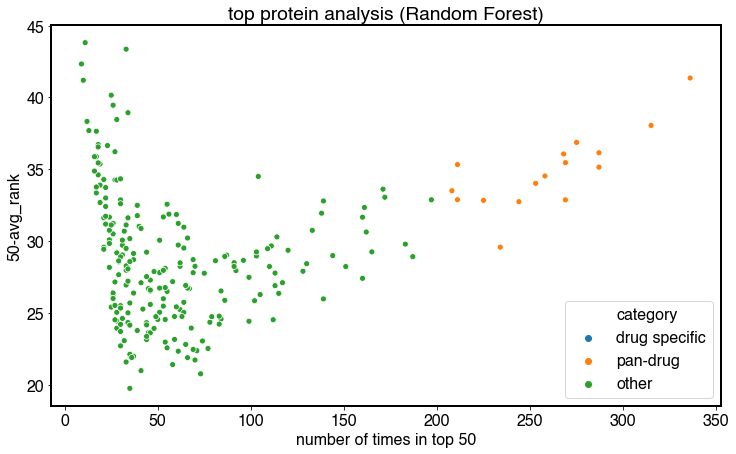

In [177]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [178]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
98,LMNA_HUMAN,41.357143,336,pan-drug
116,GBG12_HUMAN,38.053968,315,pan-drug
138,NCEH1_HUMAN,36.872727,275,pan-drug
144,ITPI2_HUMAN,36.149826,287,pan-drug
107,ANXA2_HUMAN,36.067164,268,pan-drug
118,S10AA_HUMAN,35.460967,269,pan-drug
134,GMFG_HUMAN,35.327014,211,pan-drug
13,TMED1_HUMAN,35.149826,287,pan-drug
96,PLEC_HUMAN,34.531008,258,pan-drug
223,ZFPL1_HUMAN,34.019763,253,pan-drug


### ENet

In [179]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [180]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [181]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [182]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 100 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

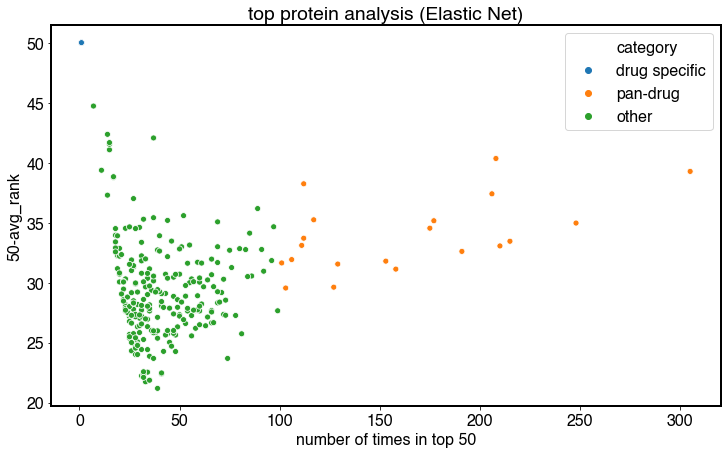

In [183]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [184]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1553,COMT_HUMAN,50.000000,1,drug specific
1524,C43BP_HUMAN,50.000000,1,drug specific
902,TPPP3_HUMAN,50.000000,1,drug specific
569,ADK_HUMAN,50.000000,1,drug specific
133,LMNA_HUMAN,40.341346,208,pan-drug
0,B2CL1_HUMAN,39.265574,305,pan-drug
134,GMFG_HUMAN,38.232143,112,pan-drug
685,SQSTM_HUMAN,37.398058,206,pan-drug
87,SPY4_HUMAN,35.230769,117,pan-drug
116,ELF1_HUMAN,35.152542,177,pan-drug


### shap

In [185]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [186]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [187]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

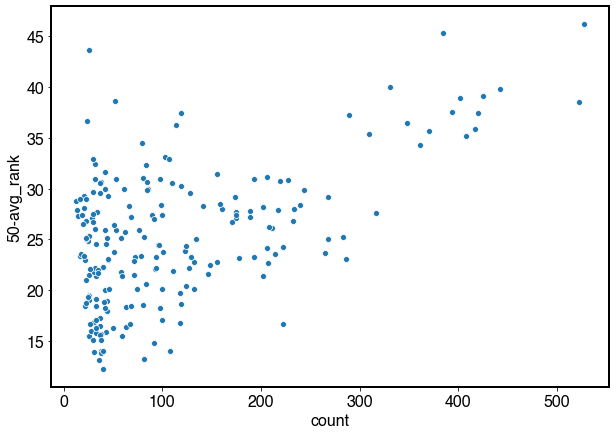

In [188]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [189]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

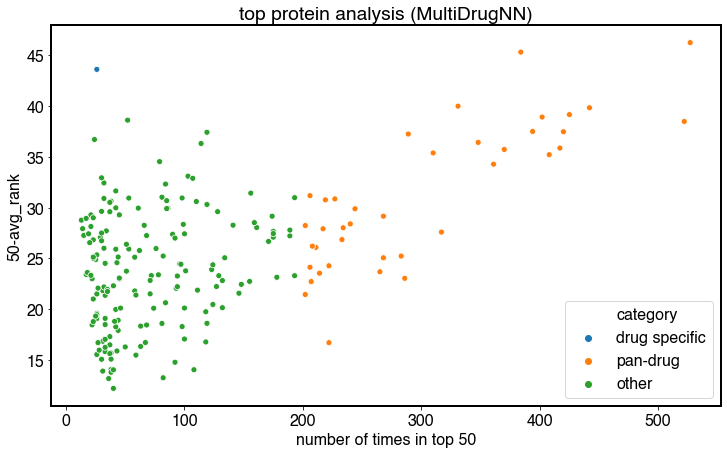

In [190]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [191]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
0,41_HUMAN,46.250474,527,pan-drug
6,PYGB_HUMAN,45.317708,384,pan-drug
73,ETHE1_HUMAN,43.615385,26,drug specific
97,LMNA_HUMAN,39.993958,331,pan-drug
1,CD97_HUMAN,39.834842,442,pan-drug
38,PTMA_HUMAN,39.162353,425,pan-drug
130,CAN2_HUMAN,38.922886,402,pan-drug
3,DNJC2_HUMAN,38.486590,522,pan-drug
46,NADC_HUMAN,37.502538,394,pan-drug
41,BID_HUMAN,37.473810,420,pan-drug


### combined

In [192]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [193]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [194]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

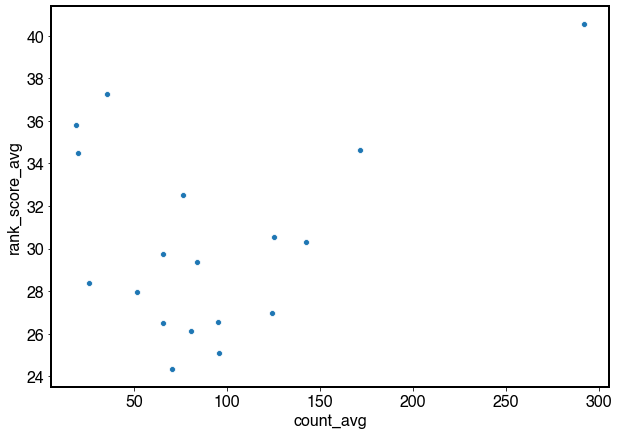

In [195]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [196]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 34 and row['count_avg'] < 50) 
    else 'pan-drug'
    if row['count_avg'] > 200 else 'other', axis=1)

In [197]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
4,LMNA_HUMAN,41.357143,336,pan-drug,40.341346,208,pan-drug,39.993958,331,pan-drug,291.666667,40.564149,pan-drug
10,GSTO1_HUMAN,36.222222,27,other,37.000000,27,other,38.615385,52,other,35.333333,37.279202,drug-specific
17,ERBB2_HUMAN,38.333333,12,other,41.533333,15,other,27.500000,30,other,19.000000,35.788889,drug-specific
16,MIEN1_HUMAN,42.333333,9,other,34.600000,30,other,26.550000,20,other,19.666667,34.494444,drug-specific


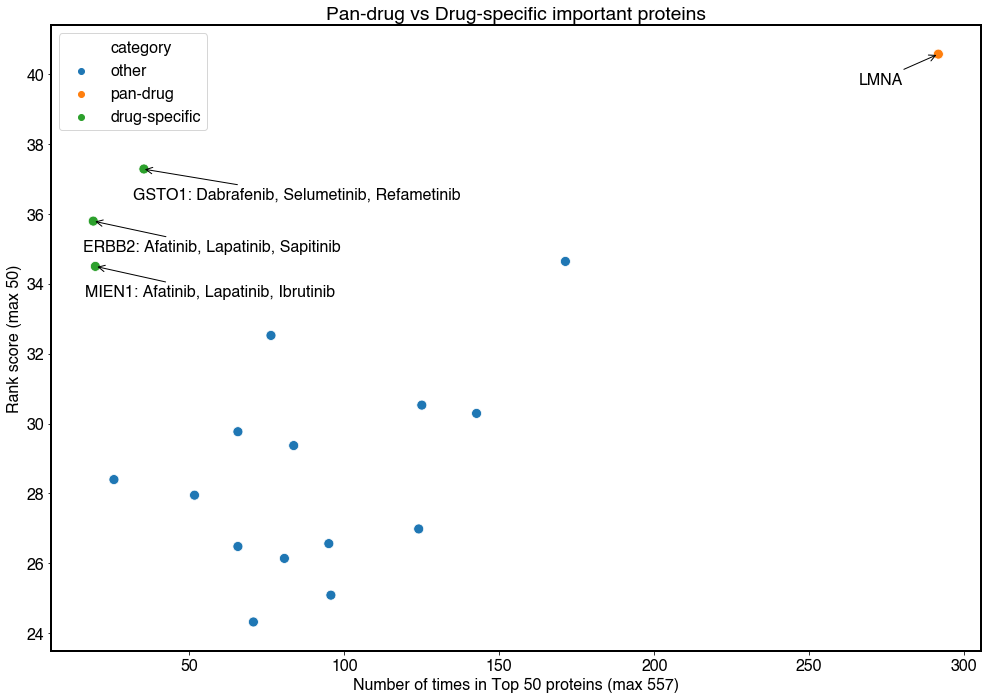

In [198]:
fig = plt.figure(figsize=(14, 10))
ax = sns.scatterplot(x='count_avg', y='rank_score_avg', hue='category_avg', data=tmp, s=100)
plt.xlabel(f"Number of times in Top 50 proteins (max {len(drug_list)})")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)

ax.annotate('ERBB2: Afatinib, Lapatinib, Sapitinib',
            xy=(19, 35.788889), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('MIEN1: Afatinib, Lapatinib, Ibrutinib',
            xy=(19.666667, 34.494444), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('GSTO1: Dabrafenib, Selumetinib, Refametinib',
            xy=(35, 37.279202), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('LMNA',
            xy=(291.666667, 40.564149), xycoords='data',
            xytext=(-80, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.tight_layout()

plt.savefig("../../plots/drug/Fig4D.pdf", dpi=500)

### drug-specific

In [122]:
ERBB2_drugs = set(shap_dict_drug['GSTO1_HUMAN']).intersection(
    set(rf_dict_drug['GSTO1_HUMAN'])).intersection(
        set(en_dict_drug['GSTO1_HUMAN']))

In [123]:
for drug in ERBB2_drugs:
    print(drug_name_map[drug])

RAF_9304
Ulixertinib
SCH772984
AZ628
Refametinib
Trametinib
PD0325901
RK-33
Trametinib
Selumetinib
PD0325901
Refametinib
Selumetinib
PLX-4720
Trametinib
Dabrafenib
AZ628
SB590885
Selumetinib


In [85]:
for drug in TMM33_drugs:
    print(drug_name_map[drug])

BAM7


## rank vs count excluding tissue - no growth

In [68]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006182114_ruv_min_300_growth_corrected_eg_id.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006201224_ruv_min_300_growth_corrected_eg_id.csv"
)
df_shap = pd.read_csv("../../result_files/shap/test_25_202006212204_growth_corrected_eg_id.csv")

In [69]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores_eg_id.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 0)][
    'drug_id'].values

In [70]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [130]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [131]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [132]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [133]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 200 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


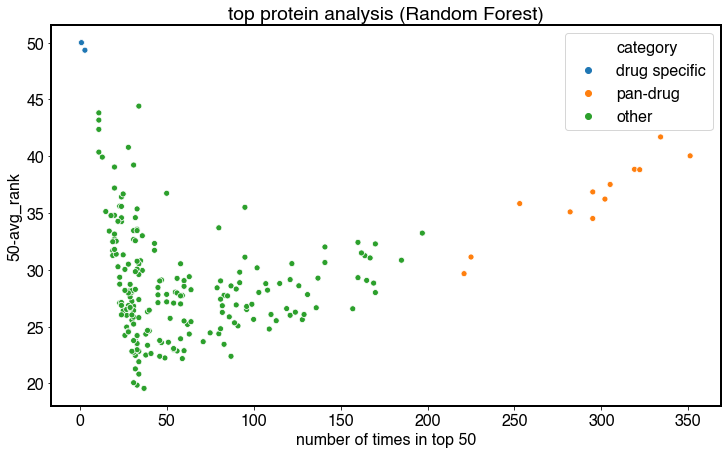

In [134]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [135]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1951,NDUB1_HUMAN,50.000000,1,drug specific
2221,HINT1_HUMAN,50.000000,1,drug specific
398,REXO4_HUMAN,49.333333,3,drug specific
103,LMNA_HUMAN,41.697605,334,pan-drug
108,GBG12_HUMAN,40.034188,351,pan-drug
135,ITPI2_HUMAN,38.849530,319,pan-drug
136,NCEH1_HUMAN,38.816770,322,pan-drug
106,ANXA2_HUMAN,37.518033,305,pan-drug
100,PLEC_HUMAN,36.857627,295,pan-drug
163,PVR_HUMAN,36.228477,302,pan-drug


### ENet

In [136]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [137]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [138]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [139]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 100 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

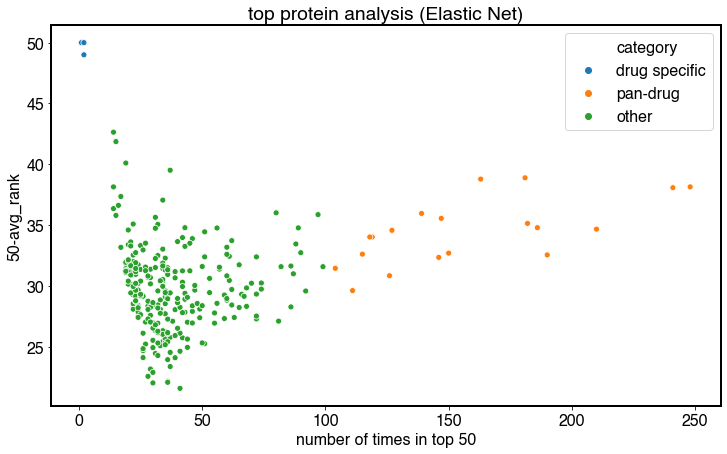

In [140]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [141]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1688,PSB5_HUMAN,50.000000,2,drug specific
564,ADK_HUMAN,50.000000,1,drug specific
1546,COMT_HUMAN,50.000000,1,drug specific
1158,TOP2A_HUMAN,50.000000,1,drug specific
1044,LIS1_HUMAN,50.000000,1,drug specific
716,GPC4_HUMAN,50.000000,1,drug specific
350,CD3E_HUMAN,49.000000,2,drug specific
137,LMNA_HUMAN,38.889503,181,pan-drug
133,GMFG_HUMAN,38.785276,163,pan-drug
1,B2CL1_HUMAN,38.145161,248,pan-drug


### shap

In [142]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [143]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [144]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

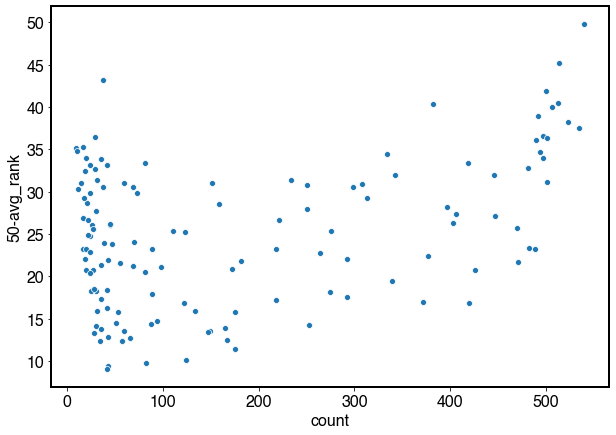

In [145]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [146]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 350 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

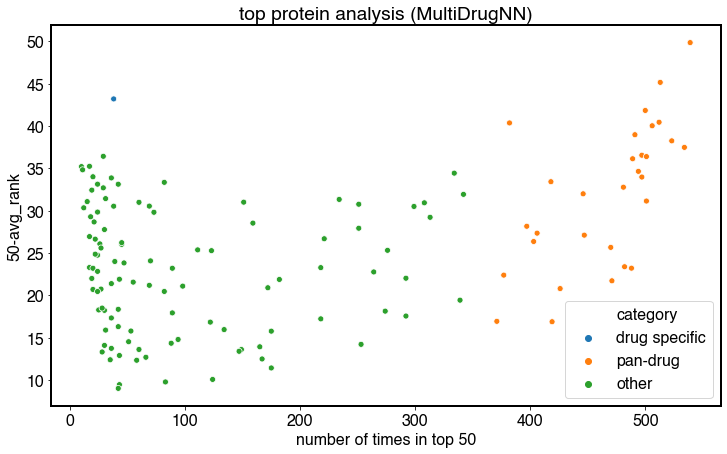

In [147]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [148]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
0,K2C7_HUMAN,49.831169,539,pan-drug
2,SCG2_HUMAN,45.138402,513,pan-drug
59,GSTO1_HUMAN,43.184211,38,drug specific
10,GSTP1_HUMAN,41.824000,500,pan-drug
3,PARP4_HUMAN,40.433594,512,pan-drug
112,PYGB_HUMAN,40.350785,382,pan-drug
20,AATC_HUMAN,40.017787,506,pan-drug
30,AGRIN_HUMAN,38.961303,491,pan-drug
8,CD97_HUMAN,38.237094,523,pan-drug
7,DNJC2_HUMAN,37.468165,534,pan-drug


### combined

In [149]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [150]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [151]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

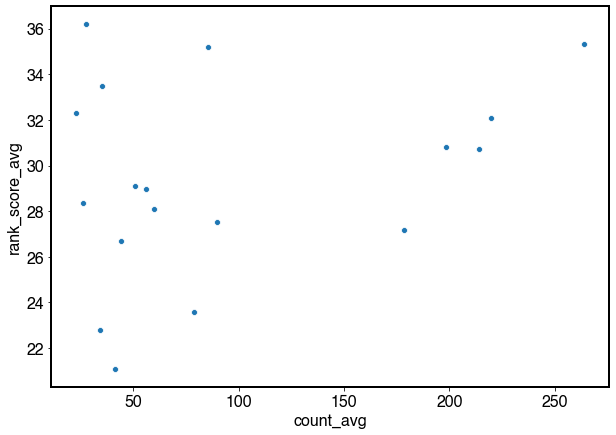

In [152]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [160]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 30 and row['count_avg'] < 50) 
    else 'pan-drug'
    if row['count_avg'] > 250 else 'other', axis=1)

In [161]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
6,GSTO1_HUMAN,34.250000,24,other,31.190476,21,other,43.184211,38,drug specific,27.666667,36.208229,drug-specific
4,LMNA_HUMAN,41.697605,334,pan-drug,38.889503,181,pan-drug,25.318841,276,other,263.666667,35.301983,pan-drug
13,PLAK_HUMAN,32.562500,32,other,34.741935,31,other,33.119048,42,other,35.000000,33.474494,drug-specific
2,ETHE1_HUMAN,32.677419,31,other,31.842105,19,other,32.421053,19,other,23.000000,32.313526,drug-specific


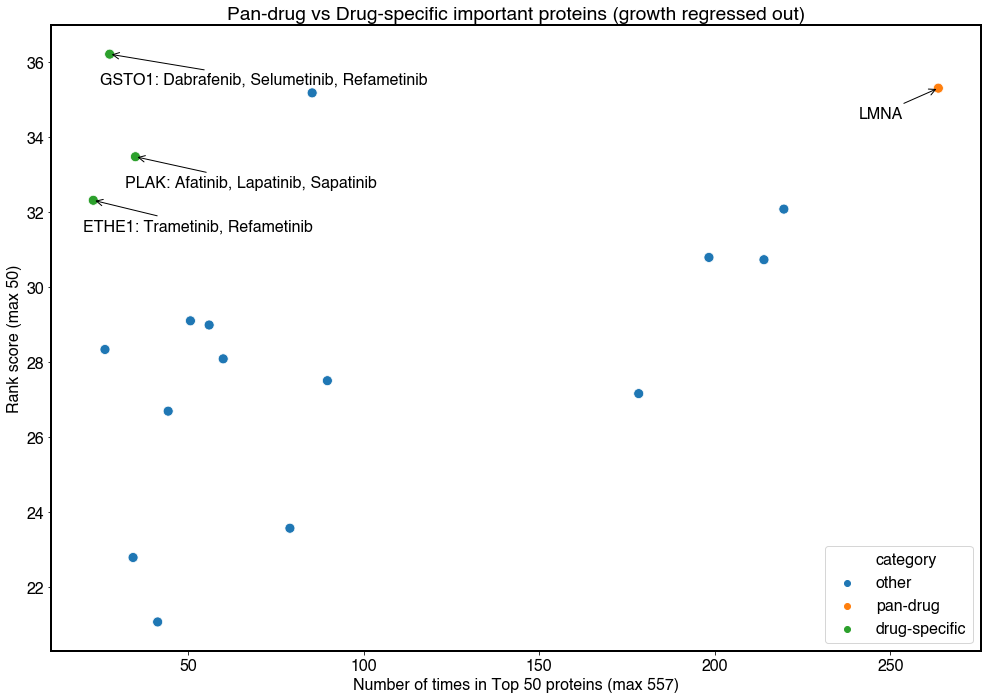

In [169]:
fig = plt.figure(figsize=(14, 10))
ax = sns.scatterplot(x='count_avg',
                     y='rank_score_avg',
                     hue='category_avg',
                     hue_order=['other', 'pan-drug', 'drug-specific'],
                     data=tmp,
                     s=100)
plt.xlabel(f"Number of times in Top 50 proteins (max {len(drug_list)})")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins (growth regressed out)")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)

ax.annotate('PLAK: Afatinib, Lapatinib, Sapatinib',
            xy=(35, 33.474494), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('GSTO1: Dabrafenib, Selumetinib, Refametinib',
            xy=(27.666667, 36.208229), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('ETHE1: Trametinib, Refametinib',
            xy=(23, 32.313526), xycoords='data',
            xytext=(-10, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

ax.annotate('LMNA',
            xy=(263.666667, 35.301983), xycoords='data',
            xytext=(-80, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.tight_layout()
plt.savefig("../../plots/drug/Fig4D-no_growth.pdf", dpi=500)

plt.show()

### drug-specific

In [165]:
PLAK_drugs = set(shap_dict_drug['PLAK_HUMAN']).intersection(
    set(rf_dict_drug['PLAK_HUMAN'])).intersection(
        set(en_dict_drug['PLAK_HUMAN']))

In [166]:
for drug in PLAK_drugs:
    print(drug_name_map[drug])

PF-06747775
AZD3759
AZD8931
Poziotinib
Ibrutinib
Gefitinib
Erlotinib
Afatinib
Afatinib
Lapatinib
Afatinib
EGF816
Sapatinib


## rank vs count excluding tissue - no PC1

In [56]:
df_rf = pd.read_csv(
    "../../work_dirs/protein/RandomForest/feature_importance_202006182115_ruv_min_300_pc1_corrected_eg_id.csv"
)
df_en = pd.read_csv(
    "../../work_dirs/protein/ElasticNet/feature_importance_202006201224_ruv_min_300_pc1_corrected_eg_id.csv"
)
df_shap = pd.read_csv("../../result_files/shap/test_25_202006212205_pc1_corrected_eg_id.csv")

In [57]:
drug_list = [1909, 1114, 1373, 1919, 1377, 119, 427, 1910, 1047]
drug_score = pd.read_csv("../../data/drug/final_drug_scores.tsv", sep="\t")
drug_list = drug_score[
    (drug_score['MultiDrug_correlation'] > 0.4) & (drug_score['sensitive_count'] > 20)][
    'drug_id'].values

In [58]:
drug_name_map = drug_score[[
    'drug_id', 'drug_name'
]].drop_duplicates().set_index('drug_id').to_dict()['drug_name']
drug_target_map = drug_score[[
    'drug_id', 'putative_gene_target'
]].drop_duplicates().set_index('drug_id').to_dict()['putative_gene_target']

### rf

In [238]:
topN = 50
rf_dict_count = {}
rf_dict_rank = {}
rf_dict_drug = {}
for drug in drug_list:
    rf_top_proteins = df_rf[['protein', f'importance_{drug}'
           ]].sort_values(by=[f'importance_{drug}'],
                          ascending=False).head(topN)['protein'].values
    rf_top_proteins = [x for x in rf_top_proteins if x not in shap_tissue_set]
    for i in range(len(rf_top_proteins)):
        if rf_top_proteins[i] not in rf_dict_count:
            rf_dict_count[rf_top_proteins[i]] = 0
            rf_dict_rank[rf_top_proteins[i]] = []
            rf_dict_drug[rf_top_proteins[i]] = []
            
        rf_dict_rank[rf_top_proteins[i]].append(i)
        rf_dict_count[rf_top_proteins[i]] += 1
        rf_dict_drug[rf_top_proteins[i]].append(drug)

In [239]:
rf_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in rf_dict_rank:
    rf_dict_rank[p] = topN - np.average(rf_dict_rank[p])
    rf_df['protein'].append(p)
    rf_df[f'{topN}-avg_rank'].append(rf_dict_rank[p])
    rf_df['count'].append(rf_dict_count[p])
rf_df = pd.DataFrame(rf_df)

In [240]:
rf_df_filtered = rf_df[rf_df['count']+rf_df[f'{topN}-avg_rank'] > topN]

In [241]:
rf_df_filtered['category'] = rf_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] > 48 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 80 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


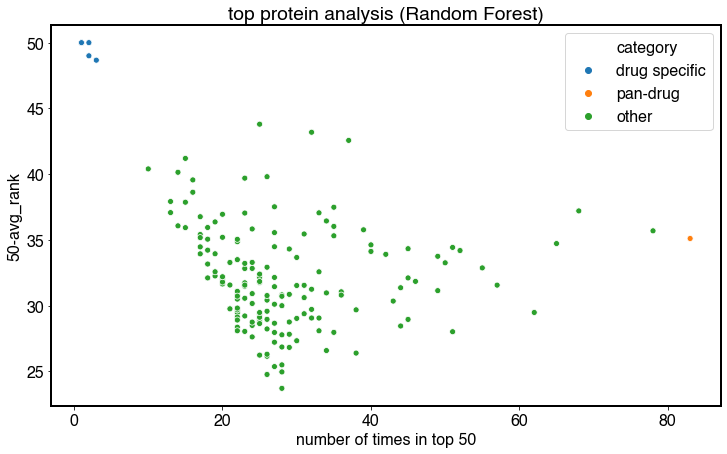

In [242]:
plt.figure(figsize=(12, 7))
g = sns.scatterplot(x='count',
                    y=f'{topN}-avg_rank',
                    hue='category',
                    hue_order=['drug specific', 'pan-drug', 'other'],
                    data=rf_df_filtered)
# for index, row in rf_df_filtered.iterrows():
#     if row['category'] != 'other':
#         g.annotate(row['protein'],
#                    xy=(row['count'], row[f'{topN}-avg_rank']),
#                    xycoords='data',
#                    xytext=(0, 20),
#                    textcoords='offset points',
#                    arrowprops=dict(arrowstyle="->"))
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Random Forest)")
plt.show()

In [243]:
rf_df_filtered[rf_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
1897,DX39B_HUMAN,50.000000,1,drug specific
2009,ADK_HUMAN,50.000000,1,drug specific
2138,STX6_HUMAN,50.000000,2,drug specific
2307,ARGI2_HUMAN,50.000000,1,drug specific
2440,ENTP1_HUMAN,50.000000,1,drug specific
2733,SYYM_HUMAN,50.000000,1,drug specific
2828,NCOR2_HUMAN,50.000000,1,drug specific
2328,SCG1_HUMAN,49.000000,2,drug specific
1420,K22E_HUMAN,48.666667,3,drug specific
288,ITB1_HUMAN,35.108434,83,pan-drug


### ENet

In [244]:
topN = 50
en_dict_count = {}
en_dict_rank = {}
en_dict_drug = {}
for drug in drug_list:
    tmp = df_en[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    en_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    en_top_proteins = [x for x in en_top_proteins if x not in shap_tissue_set]
    for i in range(len(en_top_proteins)):
        if en_top_proteins[i] not in en_dict_count:
            en_dict_count[en_top_proteins[i]] = 0
            en_dict_rank[en_top_proteins[i]] = []
            en_dict_drug[en_top_proteins[i]] = []
            
        en_dict_rank[en_top_proteins[i]].append(i)
        en_dict_count[en_top_proteins[i]] += 1
        en_dict_drug[en_top_proteins[i]].append(drug)

In [245]:
en_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in en_dict_rank:
    en_dict_rank[p] = topN - np.average(en_dict_rank[p])
    en_df['protein'].append(p)
    en_df[f'{topN}-avg_rank'].append(en_dict_rank[p])
    en_df['count'].append(en_dict_count[p])
en_df = pd.DataFrame(en_df)

In [246]:
en_df_filtered = en_df[en_df['count']+en_df[f'{topN}-avg_rank'] > topN]

In [247]:
en_df_filtered['category'] = en_df_filtered.apply(
    lambda row: 'drug specific'
    if (row[f'{topN}-avg_rank'] > topN-2 and row['count'] < 100) 
    else 'pan-drug'if (row['count'] > 80 and row[f'{topN}-avg_rank'] > 10)
    else 'other',
    axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (Elastic Net)')

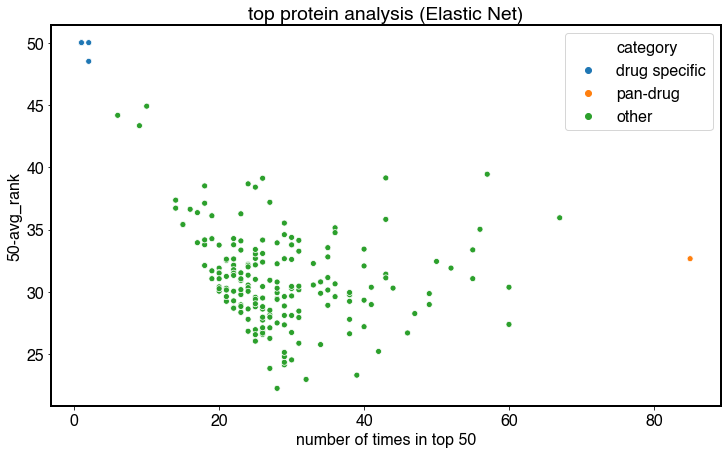

In [248]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=en_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (Elastic Net)")

In [249]:
en_df_filtered[en_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
100,PTPRF_HUMAN,50.000000,1,drug specific
500,TOP2A_HUMAN,50.000000,1,drug specific
915,IGHM_HUMAN,50.000000,1,drug specific
970,DEFI6_HUMAN,50.000000,1,drug specific
1631,MBB1A_HUMAN,50.000000,1,drug specific
1748,ENTP1_HUMAN,50.000000,2,drug specific
1959,FKBP2_HUMAN,50.000000,1,drug specific
1965,MECR_HUMAN,50.000000,1,drug specific
1364,CD3E_HUMAN,48.500000,2,drug specific
49,LEG1_HUMAN,32.658824,85,pan-drug


### shap

In [250]:
topN = 50
shap_dict_count = {}
shap_dict_rank = {}
shap_dict_drug = {}
for drug in drug_list:
    tmp = df_shap[['protein', f'importance_{drug}']]
    tmp = tmp[tmp[f'importance_{drug}'] != 0]
    tmp['abs'] = np.abs(tmp[f'importance_{drug}'])
    shap_top_proteins = tmp.sort_values(by=['abs'],
                        ascending=False)[['protein', f'importance_{drug}'
                                          ]].head(topN)['protein'].values
    shap_top_proteins = [x for x in shap_top_proteins if x not in shap_tissue_set]
    for i in range(len(shap_top_proteins)):
        if shap_top_proteins[i] not in shap_dict_count:
            shap_dict_count[shap_top_proteins[i]] = 0
            shap_dict_rank[shap_top_proteins[i]] = []
            shap_dict_drug[shap_top_proteins[i]] = []
            
        shap_dict_rank[shap_top_proteins[i]].append(i)
        shap_dict_count[shap_top_proteins[i]] += 1
        shap_dict_drug[shap_top_proteins[i]].append(drug)

In [251]:
shap_df = {'protein':[], f'{topN}-avg_rank':[], 'count':[]}
for p in shap_dict_rank:
    shap_dict_rank[p] = topN - np.average(shap_dict_rank[p])
    shap_df['protein'].append(p)
    shap_df[f'{topN}-avg_rank'].append(shap_dict_rank[p])
    shap_df['count'].append(shap_dict_count[p])
shap_df = pd.DataFrame(shap_df)

In [252]:
shap_df_filtered = shap_df[shap_df['count']+shap_df[f'{topN}-avg_rank'] > (topN-10)]

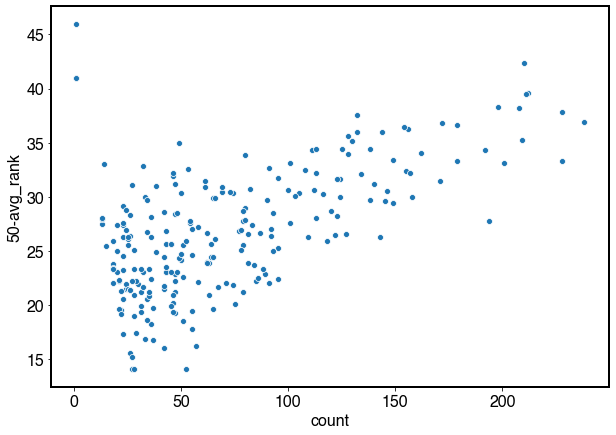

In [253]:
sns.scatterplot(x='count', y=f'{topN}-avg_rank', data=shap_df_filtered)

In [254]:
shap_df_filtered['category'] = shap_df_filtered.apply(
    lambda row: 'drug specific' if (row[f'{topN}-avg_rank'] >= 40 and row['count'] < 50) 
    else 'pan-drug'
    if row['count'] > 350 else 'other', axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'top protein analysis (MultiDrugNN)')

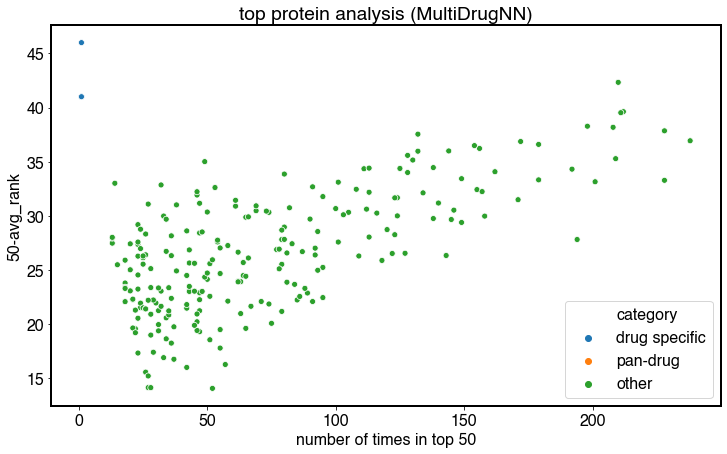

In [255]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='count',
                y=f'{topN}-avg_rank',
                hue='category',
                hue_order=['drug specific', 'pan-drug', 'other'],
                data=shap_df_filtered)
plt.xlabel(f'number of times in top {topN}')
plt.title("top protein analysis (MultiDrugNN)")

In [256]:
shap_df_filtered[shap_df_filtered['category']!='other'].sort_values([f'{topN}-avg_rank'], ascending=False)

,protein,50-avg_rank,count,category
418,ADK_HUMAN,46.0,1,drug specific
581,HMGB3_HUMAN,41.0,1,drug specific
671,PLST_HUMAN,41.0,1,drug specific


### combined

In [257]:
tmp = pd.merge(rf_df_filtered, en_df_filtered, on=['protein'], suffixes=['_rf', '_en'])

In [258]:
tmp = pd.merge(tmp, shap_df_filtered, on=['protein'])

In [259]:
tmp['count_avg'] = tmp.apply(
    lambda row: np.average([row['count'], row['count_en'], row['count_rf']]), axis=1)
tmp['rank_score_avg'] = tmp.apply(lambda row: np.average([
    row['50-avg_rank'], row['50-avg_rank_en'], row['50-avg_rank_rf']]), axis=1)

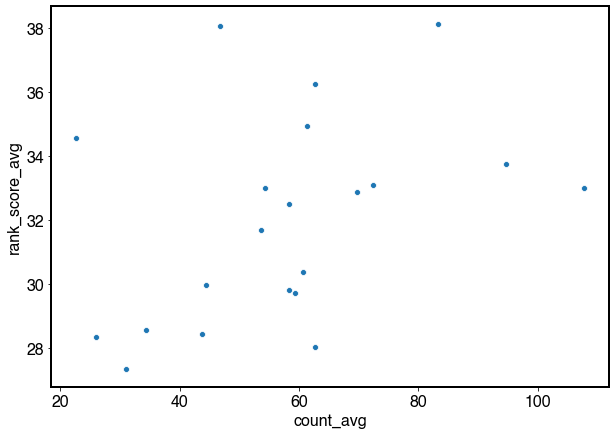

In [260]:
sns.scatterplot(x='count_avg', y='rank_score_avg', data=tmp)

In [261]:
tmp

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg
0,PLAK_HUMAN,37.485714,35,other,35.138889,36,other,32.168142,113,other,61.333333,34.930915
1,SPY4_HUMAN,42.567568,37,other,39.438596,57,other,32.217391,46,other,46.666667,38.074518
2,VTNC_HUMAN,34.192308,52,other,35.940299,67,other,20.952381,63,other,60.666667,30.361662
3,TGM2_HUMAN,29.681818,22,other,31.418605,43,other,28.026549,113,other,59.333333,29.708991
4,S10AB_HUMAN,29.761905,21,other,30.433333,30,other,21.785714,42,other,31.000000,27.326984
5,GSTO1_HUMAN,33.666667,30,other,39.115385,26,other,35.962121,132,other,62.666667,36.248057
6,NAMPT_HUMAN,38.625000,16,other,36.260870,23,other,39.521327,211,other,83.333333,38.135732
7,PDLI7_HUMAN,31.561404,57,other,32.600000,30,other,35.146154,130,other,72.333333,33.102519
8,ITA3_HUMAN,32.872727,55,other,34.129032,31,other,31.650407,123,other,69.666667,32.884055
9,ANXA2_HUMAN,28.454545,44,other,29.611111,36,other,27.565217,23,other,34.333333,28.543625


In [150]:
tmp['category_avg'] = tmp.apply(
    lambda row: 'drug-specific' if (row[f'rank_score_avg'] >= 34 and row['count_avg'] < 50) 
    else 'pan-drug'
    if row['count_avg'] > 150 else 'other', axis=1)

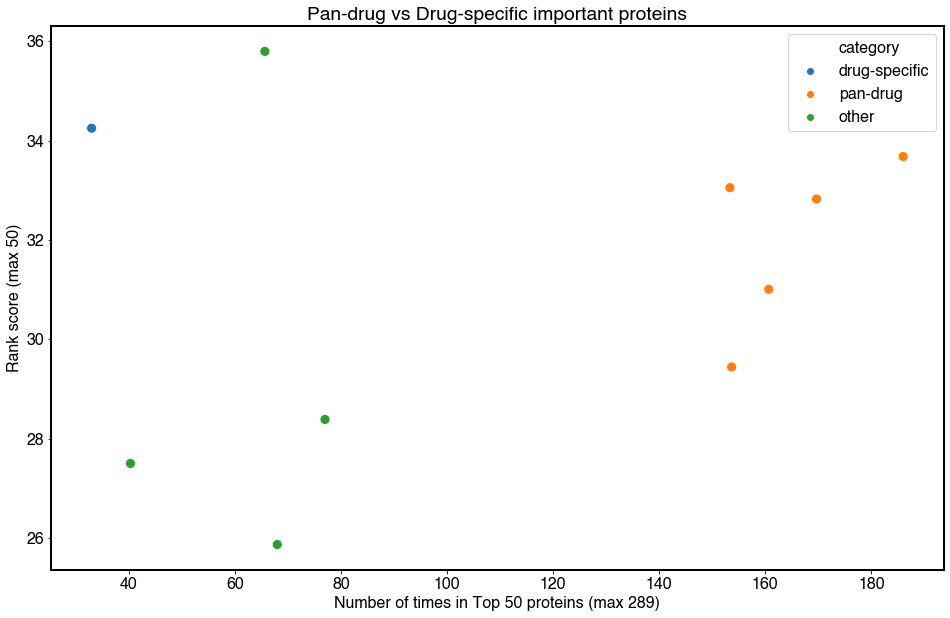

In [156]:
fig = plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x='count_avg', y='rank_score_avg', hue='category_avg', data=tmp, s=100)
plt.xlabel(f"Number of times in Top 50 proteins (max {len(drug_list)})")
plt.ylabel("Rank score (max 50)")
plt.title("Pan-drug vs Drug-specific important proteins")
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'category'
ax.legend(handles, labels)

plt.show()

In [152]:
tmp[tmp['category_avg']!='other'].sort_values([f'rank_score_avg'], ascending=False)

,protein,50-avg_rank_rf,count_rf,category_rf,50-avg_rank_en,count_en,category_en,50-avg_rank,count,category,count_avg,rank_score_avg,category_avg
0,PLAK_HUMAN,36.625000,24,other,34.920000,25,other,31.200000,50,other,33.000000,34.248333,drug-specific
5,LMNA_HUMAN,39.730159,252,pan-drug,37.739837,123,pan-drug,23.562842,183,other,186.000000,33.677613,pan-drug
1,COF2_HUMAN,33.407407,27,other,32.378378,74,other,33.364903,359,pan-drug,153.333333,33.050229,pan-drug
3,PTMA_HUMAN,26.949153,59,other,35.016667,60,other,36.502564,390,pan-drug,169.666667,32.822794,pan-drug
6,VTNC_HUMAN,24.378378,37,other,37.237805,164,pan-drug,31.398577,281,other,160.666667,31.004920,pan-drug
8,GDIR2_HUMAN,27.640449,89,other,26.032258,31,other,34.653959,341,other,153.666667,29.442222,pan-drug


### drug-specific

In [153]:
PLAK_drugs = set(shap_dict_drug['PLAK_HUMAN']).intersection(
    set(rf_dict_drug['PLAK_HUMAN'])).intersection(
        set(en_dict_drug['PLAK_HUMAN']))

In [155]:
for drug in PLAK_drugs:
    print(drug_name_map[drug])

Afatinib
Poziotinib
EGF816
PF-06747775
Ibrutinib
AZD8931
Sapatinib
Erlotinib
Gefitinib
Lapatinib


## specific drugs

In [59]:
name_map = pd.read_csv("../../data/misc/HUMAN_9606_idmapping.gene_prot.dat",
                       sep='\t',
                       names=['ID', 'type', 'code'])
name_map = name_map.drop_duplicates(['ID', 'type'])
name_map = pd.pivot(name_map, index='ID', columns='type', values='code').dropna()

name_map_dict = dict(zip(name_map['UniProtKB-ID'].values, name_map['Gene_Name'].values))

In [60]:
drug_id = '1373;Dabrafenib;GDSC1'

In [61]:
topN = 50
top_proteins = []

In [62]:
df_en_drug = df_en[['protein',
                    f'importance_{drug_id}']].set_index('protein').sort_values(
                        by=f'importance_{drug_id}', ascending=False)
df_en_drug['abs'] = df_en_drug[f'importance_{drug_id}'].abs()
df_en_drug = df_en_drug.sort_values(by=['abs'], ascending=False).reset_index()
top_proteins.extend(df_en_drug['protein'].values[:topN])

In [63]:
df_en_drug.head(20)

,protein,importance_1373;Dabrafenib;GDSC1,abs
0,SPY4_HUMAN,-0.125978,0.125978
1,TGM2_HUMAN,-0.123281,0.123281
2,PMEL_HUMAN,-0.114684,0.114684
3,RGS10_HUMAN,-0.103177,0.103177
4,ITB3_HUMAN,-0.092000,0.092000
5,ASSY_HUMAN,0.076192,0.076192
6,TRPV2_HUMAN,-0.075912,0.075912
7,HMGA2_HUMAN,-0.075286,0.075286
8,GSTO1_HUMAN,-0.071718,0.071718
9,RETST_HUMAN,-0.069954,0.069954


In [64]:
df_rf_drug = df_rf[['protein',
                    f'importance_{drug_id}']].set_index('protein').sort_values(
                        by=f'importance_{drug_id}', ascending=False)
df_rf_drug['abs'] = df_rf_drug[f'importance_{drug_id}'].abs()
df_rf_drug = df_rf_drug.sort_values(by=['abs'], ascending=False).reset_index()
top_proteins.extend(df_rf_drug['protein'].values[:topN])

In [65]:
df_rf_drug.head(20)

,protein,importance_1373;Dabrafenib;GDSC1,abs
0,MAR1_HUMAN,0.009680,0.009680
1,CP27A_HUMAN,0.007787,0.007787
2,SPY4_HUMAN,0.006548,0.006548
3,PMEL_HUMAN,0.006536,0.006536
4,TYRP2_HUMAN,0.005720,0.005720
5,GPNMB_HUMAN,0.005719,0.005719
6,VIME_HUMAN,0.005403,0.005403
7,PIR_HUMAN,0.004944,0.004944
8,SDCB1_HUMAN,0.004719,0.004719
9,ITB3_HUMAN,0.004490,0.004490


In [66]:
df_dl_drug = df_shap[['protein',
                    f'importance_{drug_id}']].set_index('protein').sort_values(
                        by=f'importance_{drug_id}', ascending=False)
df_dl_drug['abs'] = df_dl_drug[f'importance_{drug_id}'].abs()
df_dl_drug = df_dl_drug.sort_values(by=['abs'], ascending=False).reset_index()


In [67]:
df_dl_drug.head(20)

,protein,importance_1373;Dabrafenib;GDSC1,abs
0,VIME_HUMAN,0.021279,0.021279
1,GSTO1_HUMAN,0.019599,0.019599
2,ANXA5_HUMAN,0.018607,0.018607
3,GELS_HUMAN,0.016939,0.016939
4,PGRC1_HUMAN,0.016041,0.016041
5,HBA_HUMAN,0.016023,0.016023
6,SPY4_HUMAN,0.015745,0.015745
7,TGM2_HUMAN,0.014764,0.014764
8,AGR2_HUMAN,0.013940,0.013940
9,PCAT2_HUMAN,0.013832,0.013832


# check tissue type overlap

In [292]:
ic50 = pd.read_csv("../../data/drug/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [255]:
tissue_proteins = pd.read_excel(
    "../../result_files/tissue_top_100_proteins.xlsx",
    sheet_name='Top50_all')['protein'].values

In [256]:
cancer_proteins = pd.read_excel(
    "../../result_files/cancer_top_100_proteins.xlsx",
    sheet_name='Top50_all')['protein'].values

In [280]:
df_overlap = []
for drug_id in df_shap.drop(['protein'], axis=1).columns:
    top_proteins_shap = df_shap['protein'].values[np.argsort(
        -df_shap[drug_id].values)[:50]]
    top_proteins_rf = df_rf['protein'].values[np.argsort(
        -df_rf[drug_id].values)[:50]]
    top_proteins_en = df_en['protein'].values[np.argsort(
        -df_en[drug_id].values)[:50]]

    tissue_overlap_en = len(set(top_proteins_en).intersection(tissue_proteins))
    cancer_overlap_en = len(set(top_proteins_en).intersection(cancer_proteins))

    tissue_overlap_rf = len(set(top_proteins_rf).intersection(tissue_proteins))
    cancer_overlap_rf = len(set(top_proteins_rf).intersection(cancer_proteins))

    tissue_overlap_shap = len(set(top_proteins_shap).intersection(tissue_proteins))
    cancer_overlap_shap = len(set(top_proteins_shap).intersection(cancer_proteins))
    df_overlap.append({
        'drug_id': drug_id,
        'tissue_overlap_en': tissue_overlap_en,
        'cancer_overlap_en': cancer_overlap_en,
        'tissue_overlap_rf': tissue_overlap_rf,
        'cancer_overlap_rf': cancer_overlap_rf,
        'tissue_overlap_dl': tissue_overlap_shap,
        'cancer_overlap_dl': cancer_overlap_shap,
        'tissue_overlap_avg': np.mean([tissue_overlap_en, tissue_overlap_rf,tissue_overlap_shap]),
        'cancer_overlap_avg': np.mean([cancer_overlap_en, cancer_overlap_rf,cancer_overlap_shap])
    })
df_overlap = pd.DataFrame(df_overlap)
df_overlap['drug_id'] = df_overlap['drug_id'].map(
    lambda x: x.replace('importance_', ''))

In [284]:
df_overlap.sort_values(by=['tissue_overlap_avg'], ascending=False).head(20)

,drug_id,tissue_overlap_en,cancer_overlap_en,tissue_overlap_rf,cancer_overlap_rf,tissue_overlap_dl,cancer_overlap_dl,tissue_overlap_avg,cancer_overlap_avg
348,1036;PLX-4720;GDSC2,18,12,23,22,18,12,19.666667,15.333333
99,1382;AZD3514;GDSC1,21,12,21,13,16,14,19.333333,13.000000
93,1373;Dabrafenib;GDSC1,19,12,23,17,15,12,19.000000,13.666667
305,1598;LGK974;GDSC2,21,13,21,16,15,10,19.000000,13.000000
30,1010;Gefitinib;GDSC1,16,8,22,11,19,12,19.000000,10.333333
411,1993;THZ1;GDSC2,18,16,21,22,18,11,19.000000,16.333333
58,1061;SB590885;GDSC1,16,10,22,15,18,11,18.666667,12.000000
52,1039;SL0101;GDSC1,18,10,21,12,17,12,18.666667,11.333333
450,2152;I-BET151;GDSC2,18,19,21,21,17,11,18.666667,17.000000
286,1168;Erlotinib;GDSC2,14,7,20,13,22,14,18.666667,11.333333


In [289]:
drug_list = ['1549;Sapatinib;GDSC2', '1079;Dasatinib;GDSC2', '1032;Afatinib;GDSC1']

In [287]:
drug_list = [
    '1053;MK-2206;GDSC2', '1924;Ipatasertib;GDSC2', '1918;AZD8186;GDSC2',
    '1933;P22077;GDSC2', '2170;AT13148;GDSC2'
]

In [301]:
ic50[ic50['drug_id']=='1032;Afatinib;GDSC1']['max_screening_conc']

14299     0.5
14655     0.5
14945     0.5
15267     0.5
15624     0.5
         ... 
316865    0.5
317143    0.5
317423    0.5
317700    0.5
317978    0.5
Name: max_screening_conc, Length: 930, dtype: float64

In [290]:
df_overlap[df_overlap['drug_id'].isin(drug_list)]

,drug_id,tissue_overlap_en,cancer_overlap_en,tissue_overlap_rf,cancer_overlap_rf,tissue_overlap_dl,cancer_overlap_dl,tissue_overlap_avg,cancer_overlap_avg
48,1032;Afatinib;GDSC1,14,9,17,10,17,12,16.0,10.333333
296,1549;Sapatinib;GDSC2,14,10,17,11,17,12,16.0,11.000000
298,1079;Dasatinib;GDSC2,12,12,16,10,20,16,16.0,12.666667


In [286]:
df_overlap.sort_values(by=['tissue_overlap_avg'], ascending=False).to_csv(
    "../../result_files/cancer_tissue_type/top_feature_tissue_cancer_overlap_growth_regressed.csv",
    index=False)